<a href="https://colab.research.google.com/github/ErdemKilci/ReservoirWind/blob/main/reservoir_wind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas matplotlib openpyxl


<ipython-input-4-7a29ccb6f391>:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=current_datetime, periods=num_rows, freq='H')
<ipython-input-4-7a29ccb6f391>:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=current_datetime, periods=num_rows, freq='H')
<ipython-input-4-7a29ccb6f391>:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=current_datetime, periods=num_rows, freq='H')
<ipython-input-4-7a29ccb6f391>:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=current_datetime, periods=num_rows, freq='H')
<ipython-input-4-7a29ccb6f391>:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_rang

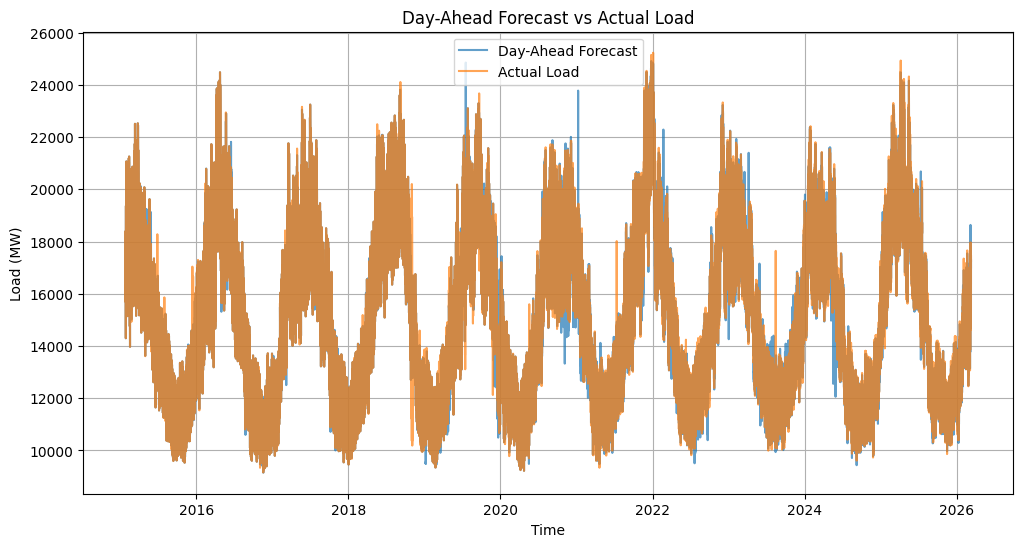

In [ ]:

import pandas as pd
import os
import matplotlib.pyplot as plt

# Example for file path
data_folder = "Data"
excel_files = sorted([f for f in os.listdir(data_folder) if f.endswith('.xlsx')])  # Sort files chronologically

all_data = pd.DataFrame()

# Manually define the initial start date
current_datetime = pd.Timestamp("2014-01-01 00:00:00")  # Adjust based on the first file

for file in excel_files:
    file_path = os.path.join(data_folder, file)
    # Read Excel file
    data = pd.read_excel(file_path, skiprows=3)  # Skip metadata rows

    # Rename columns
    data.columns = ['Time', 'Forecast Load', 'Actual Load']

    # Remove the first two rows that don't contain useful data
    data = data.iloc[2:].reset_index(drop=True)

    # Use a counter to process 24 rows and skip the next 3 rows, with reset logic
    filtered_data = pd.DataFrame()
    count = 0  # Counter for rows
    skip = 1  # Tracks rows to be skipped

    for index, row in data.iterrows():
        # If we are in the skipping phase, decrement the skip counter and continue
        if skip > 0:
            skip -= 1
            continue

        # Include the current row in the filtered_data
        filtered_data = pd.concat([filtered_data, pd.DataFrame([row])])
        count += 1

        # Once 24 rows are processed, skip the next 3 rows and reset the counter
        if count == 24:
            skip = 3  # Set skip counter for the next 3 rows
            count = 0  # Reset the counter

    # Generate timestamps dynamically based on the current_datetime
    num_rows = len(filtered_data)
    time_range = pd.date_range(start=current_datetime, periods=num_rows, freq='H')
    filtered_data['Time'] = time_range

    # Update current_datetime to continue from the end of this file's data
    current_datetime = time_range[-1] + pd.Timedelta(hours=1)

    # Convert columns to numeric, preserving NaN values
    filtered_data['Forecast Load'] = pd.to_numeric(filtered_data['Forecast Load'], errors='coerce')
    filtered_data['Actual Load'] = pd.to_numeric(filtered_data['Actual Load'], errors='coerce')

    # Append to the combined DataFrame
    all_data = pd.concat([all_data, filtered_data[['Time', 'Forecast Load', 'Actual Load']]], ignore_index=True)

# Verify the range of the data
print("Time range in data:", all_data['Time'].min(), "to", all_data['Time'].max())

# Plot the data, including null values
plt.figure(figsize=(12, 6))
plt.plot(all_data['Time'], all_data['Forecast Load'], label='Day-Ahead Forecast', alpha=0.7, color='blue')
plt.plot(all_data['Time'], all_data['Actual Load'], label='Actual Load', alpha=0.7, color='orange')
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.title('Day-Ahead Forecast vs Actual Load (With Skipped Rows)')
plt.legend()
plt.grid()
plt.show()



In [ ]:
print(f"Data from file {file}:")
print(data.head())

print("All Data Summary:")
print(all_data.info())
print(all_data.head())
print(all_data.tail())

print(f"Timestamps for file {file}:")
print(data['Time'].head())

print("Missing data summary:")
print(all_data.isna().sum())


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Add Forecast and Actual Load lines
fig.add_trace(go.Scatter(x=all_data['Time'], y=all_data['Forecast Load'],
                         mode='lines', name='Day-Ahead Forecast', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=all_data['Time'], y=all_data['Actual Load'],
                         mode='lines', name='Actual Load', line=dict(color='orange')))

# Highlight no-wind periods
no_wind_periods = all_data[(all_data['Forecast Load'].isna()) & (all_data['Actual Load'].isna())]
fig.add_trace(go.Scatter(x=no_wind_periods['Time'], y=[None]*len(no_wind_periods),
                         mode='markers', name='No Wind Periods', marker=dict(color='red', symbol='x')))

fig.update_layout(
    title='Day-Ahead Forecast vs Actual Load (With Gaps Highlighted)',
    xaxis_title='Time',
    yaxis_title='Load (MW)',
    legend=dict(orientation="h"),
    template='plotly_white'
)

fig.show()